# RNAseq analysis workflow using DESeq2

In [46]:
library("DESeq2")
library(scales)
library(data.table)
library(pheatmap)

Navigate to the correct directory:

In [2]:
setwd(path.expand("/mnt/storage/r0773125/jupyternotebooks/RNA-seq"))

Define the file containing the raw counts (the ones we generated last session):

In [3]:
matrixFile = path.expand("/mnt/storage/r0773125/jupyternotebooks/RNA-seq/all.gene.counts")

In [4]:
# read in count data
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))

In [5]:
colnames(countData) <- c("YT1", "YT2", "YS1", "YS2")
head(countData)

,YT1,YT2,YS1,YS2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,0
RP11-34P13.8,0,0,0,0
AL627309.1,18,23,10,15


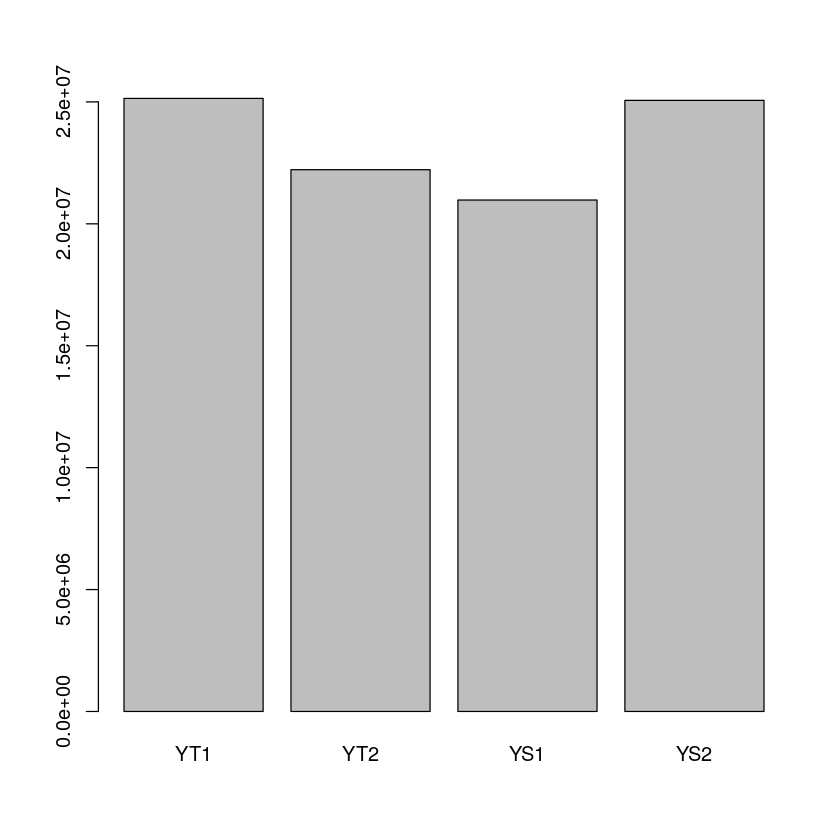

In [6]:
# amount of reads per sample
barplot(colSums(countData))

Define the experimental conditions:

In [7]:
condition <- factor(c("YT", "YT", "YS", "YS"))
print(condition)

[1] YT YT YS YS
Levels: YS YT


Prepare a dataframe with the names and conditions. This will be fed to DESeq2.

In [8]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
YT1,YT
YT2,YT
YS1,YS
YS2,YS


Here we create a DESeq `DESeqDataSet` object for subsequent analysis:

In [9]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
#we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)

In [10]:
dds

class: DESeqDataSet 
dim: 41863 4 
metadata(1): version
assays(1): counts
rownames(41863): MIR1302-11 FAM138A ... AC007965.1 RNU6-1314P
rowData names(0):
colnames(4): YT1 YT2 YS1 YS2
colData names(2): sampleName condition

Confirm that the order is still correct:

In [11]:
dds$condition

[1] YT YT YS YS
Levels: YS YT

## Run the differential expression:

one function within `DESeq2` runs all steps required:

In [12]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# Quality Control
The next step in the DESeq2 workflow is QC, which includes sample-level and gene-level steps to perform QC checks on the count data to help us ensure that the samples/replicates look good.

## Sample-level QC
A useful initial step in an RNA-seq analysis is often to assess overall similarity between samples:

- Which samples are similar to each other, which are different?
- Does this fit to the expectation from the experiment’s design?
- What are the major sources of variation in the dataset?

To explore the similarity of our samples, we will be performing sample-level QC using Principal Component Analysis (PCA) and hierarchical clustering methods. Our sample-level QC allows us to see how well our replicates cluster together, as well as, observe whether our experimental condition represents the major source of variation in the data. Performing sample-level QC can also identify any sample outliers, which may need to be explored further to determine whether they need to be removed prior to DE analysis. Naturally, some of these analyses don't make much sense when we only have two conditions, each with two replicates. But it's useful to illustrate nonetheless and I wanted to show I made the effort to go further in depth with the QC.

When using these unsupervised clustering methods, log2-transformation of the normalized counts improves the clustering for visualization. DESeq2 uses a regularized log transform (rlog) of the normalized counts for sample-level QC as it moderates the variance across the mean, improving the clustering.

### Principle Components Analysis
If two samples have similar levels of expression for the genes that contribute significantly to the variation represented by PC1, they will be plotted close together on the PC1 axis. Therefore, we would expect that biological replicates to have similar scores (since the same genes are changing) and cluster together on PC1 and/or PC2, and the samples from different treatment groups to have different score. This is easiest to understand by visualising example PCA plots.

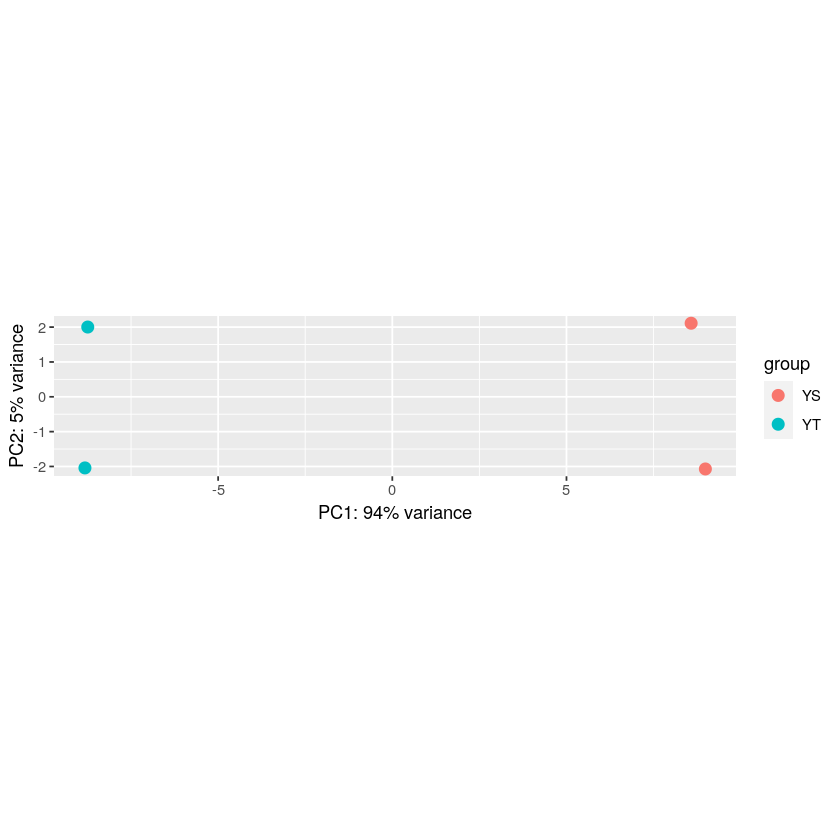

In [13]:
# Transform counts for data visualization
rld <- rlog(dds, blind=TRUE)
plotPCA(rld, intgroup="condition")

The PCA plot shows that the first principle component contains 94% of the variance, and that the conditions are well separated along this dimension. The replicates are further separated by the second principle component, although this only accounts for 2.5% of the variance.

### Hierarchical Clustering Heatmap
Similar to PCA, hierarchical clustering is another, complementary method for identifying strong patterns in a dataset and potential outliers. The heatmap displays the correlation of gene expression for all pairwise combinations of samples in the dataset. Since the majority of genes are not differentially expressed, samples generally have high correlations with each other. Samples below 0.80 may indicate sample contamination.

The hierarchical tree can indicate which samples are more similar to each other based on the normalized gene expression values. The color blocks indicate substructure in the data, and you would expect to see your replicates cluster together as a block for each sample group. Additionally, we expect to see samples clustered similar to the groupings observed in a PCA plot.

Since there is no built-in function for heatmaps in DESeq2 we will be using the `pheatmap()` function from the pheatmap package. This function requires a matrix/dataframe of numeric values as input, and so the first thing we need to is retrieve that information from the rld object:

In [30]:
rld_mat <- assay(rld)

Compute the pairwise correlation values for samples using the `cor()` function:

In [31]:
rld_cor <- cor(rld_mat)

Plot the correlation values as a heatmap:

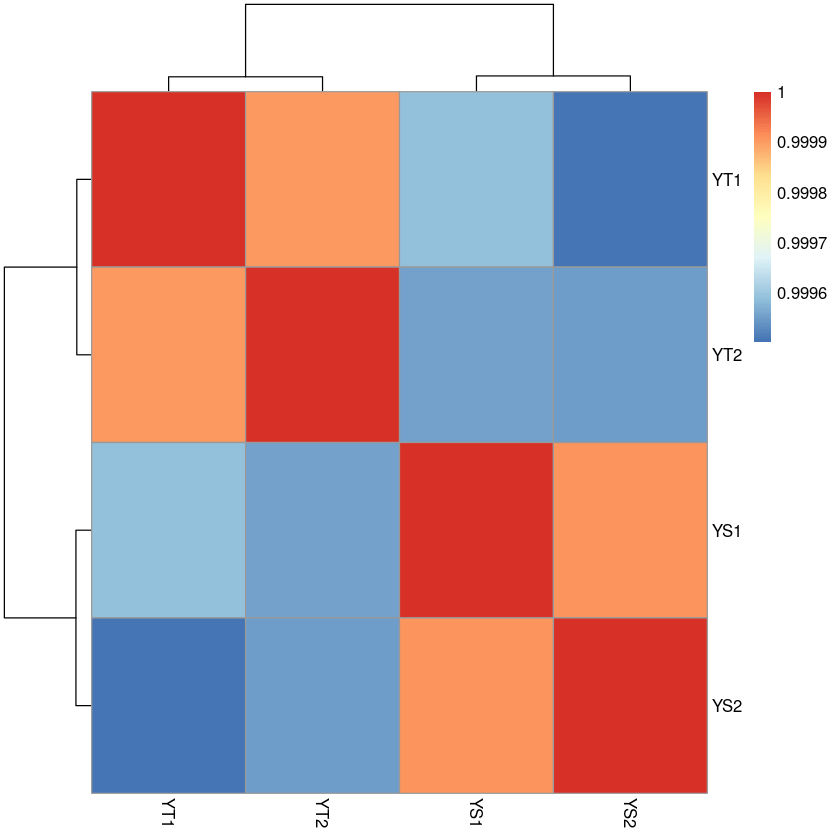

In [34]:
pheatmap(rld_cor)

The replicates cluster together as expected. 

Lastly, we can make scatter plot of sample vs sample will show us how the samples compare. It is clear that the replicates are more similar to each other than between conditions.

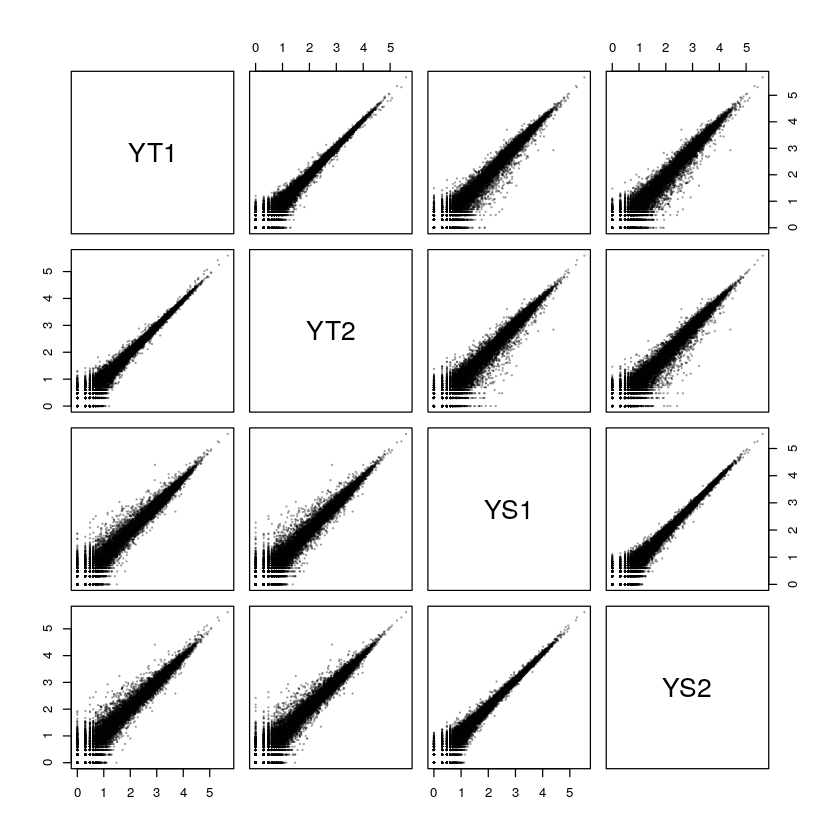

In [35]:
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

### Gene-level QC
Prior to differential expression analysis it is beneficial to omit genes that have little or no chance of being detected as differentially expressed. DESeq does this by default however so I won't get into this here.

# Differential Expression Analysis
The count data generated by RNA-seq exhibits overdispersion (variance > mean) and the statistical distribution used to model the counts needs to account for this overdispersion. DESeq2 uses a negative binomial distribution to model the RNA-seq counts.

DESeq2 will use this formula as our model for each gene, and fit the normalized count data to it. After the model is fit, coefficients are estimated for each sample group along with their standard error. The coefficents are the estimates for the log2 foldchanges for each sample group. However, these estimates do not account for the large dispersion we observe with low read counts. To avoid this, the log2 fold changes calculated by the model need to be adjusted.

## Shrunken log2 foldchanges (LFC)
To generate more accurate log2 foldchange estimates, DESeq2 allows for the shrinkage of the LFC estimates toward zero when the information for a gene is low, which could include:

 - Low counts
 - High dispersion values

As with the shrinkage of dispersion estimates, LFC shrinkage uses information from all genes to generate more accurate estimates. Specifically, the distribution of LFC estimates for all genes is used (as a prior) to shrink the LFC estimates of genes with little information or high dispersion toward more likely (lower) LFC estimates.

In [47]:
# results for unshrunken and shrunked LFCs
res_unshrunken <- results(dds, alpha = 0.05)
contrast <- c("condition", "YT", "YS")
res_shrunken <- lfcShrink(dds, contrast=contrast, res=res_unshrunken)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



## MA plot
The MA plot shows the mean of the normalized counts versus the log2 foldchanges for all genes tested. The genes that are significantly DE are colored to be easily identified. We can use the MA plot to view the effects of LFC shrinkage

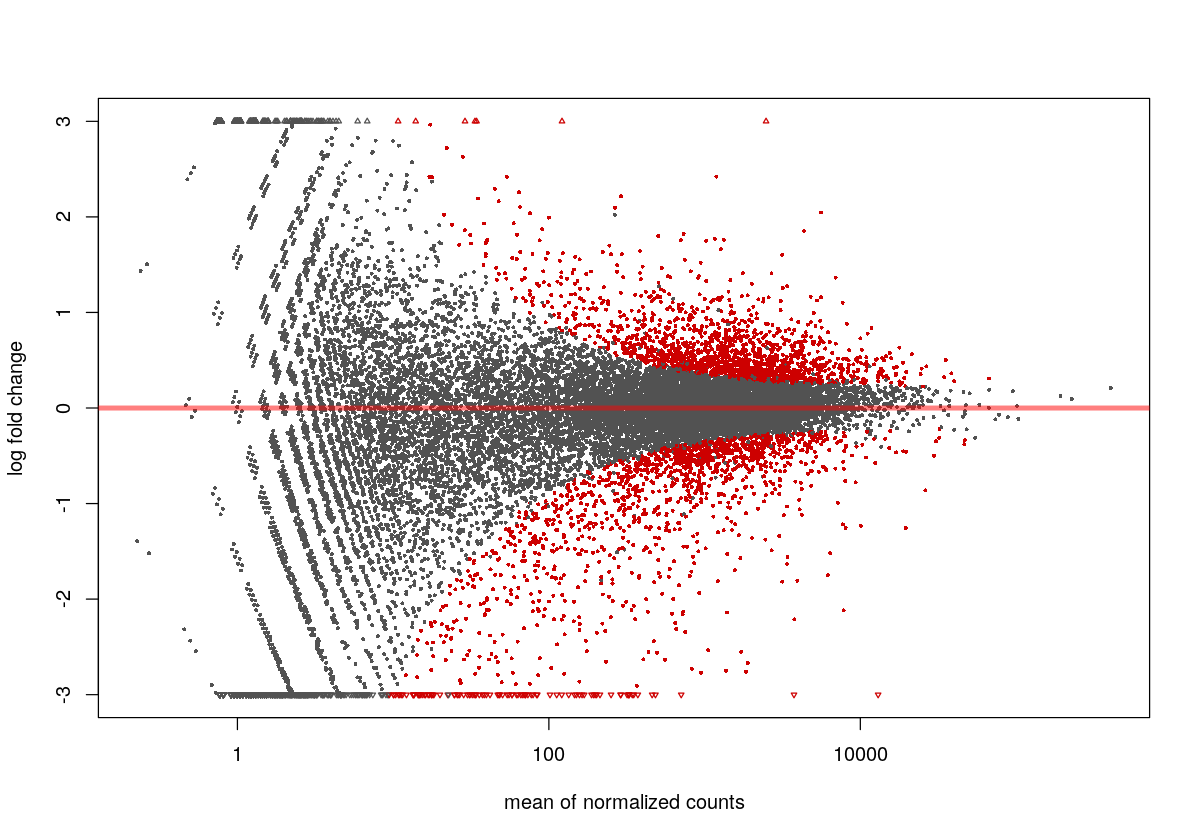

In [52]:
options(repr.plot.width=10, repr.plot.height=7)
plotMA(res_unshrunken, ylim=c(-3,3))

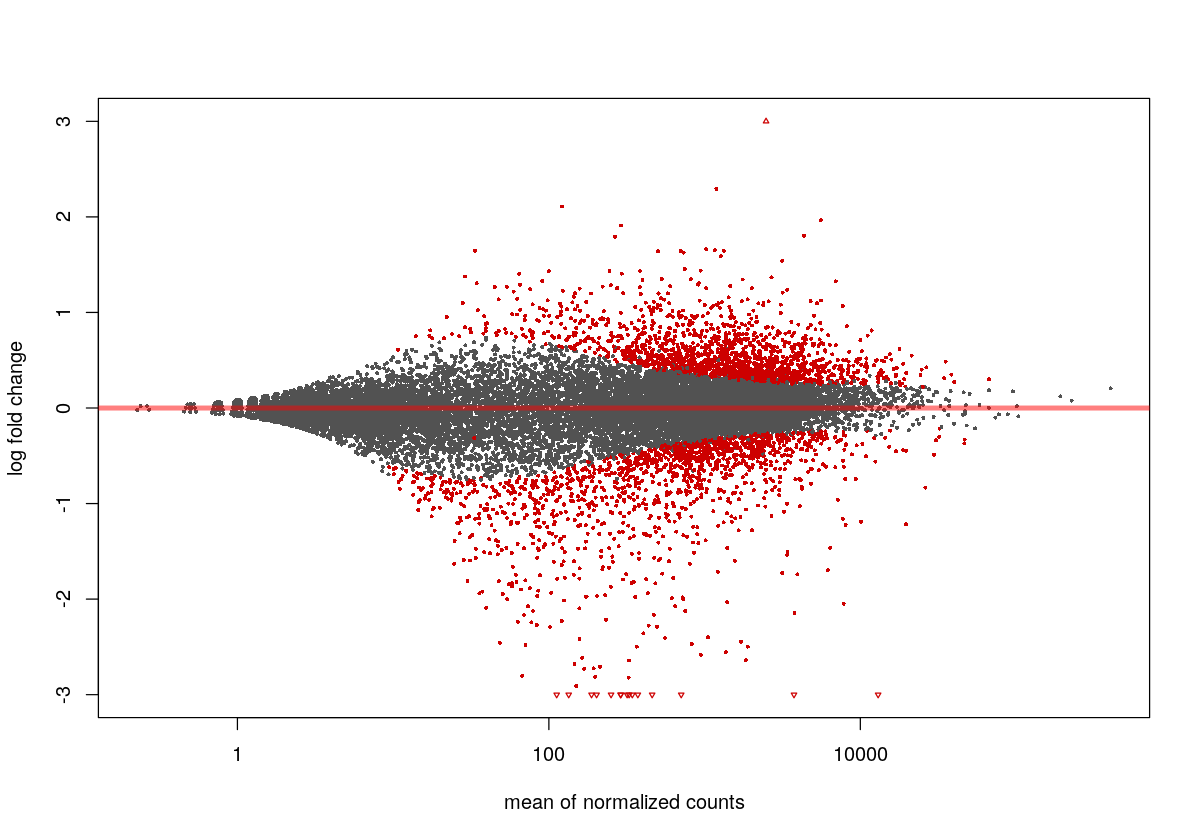

In [53]:
options(repr.plot.width=10, repr.plot.height=7)
plotMA(res_shrunken, ylim=c(-3,3))

We can clearly see the effects of LFC shrinkage here. Furthermore, it seems that there are more significantly downregulated genes with high LFCs.

# Export and visualise the results

In [57]:
res <- res_shrunken[order(res$padj),]

In [58]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)

[1] 3011    6

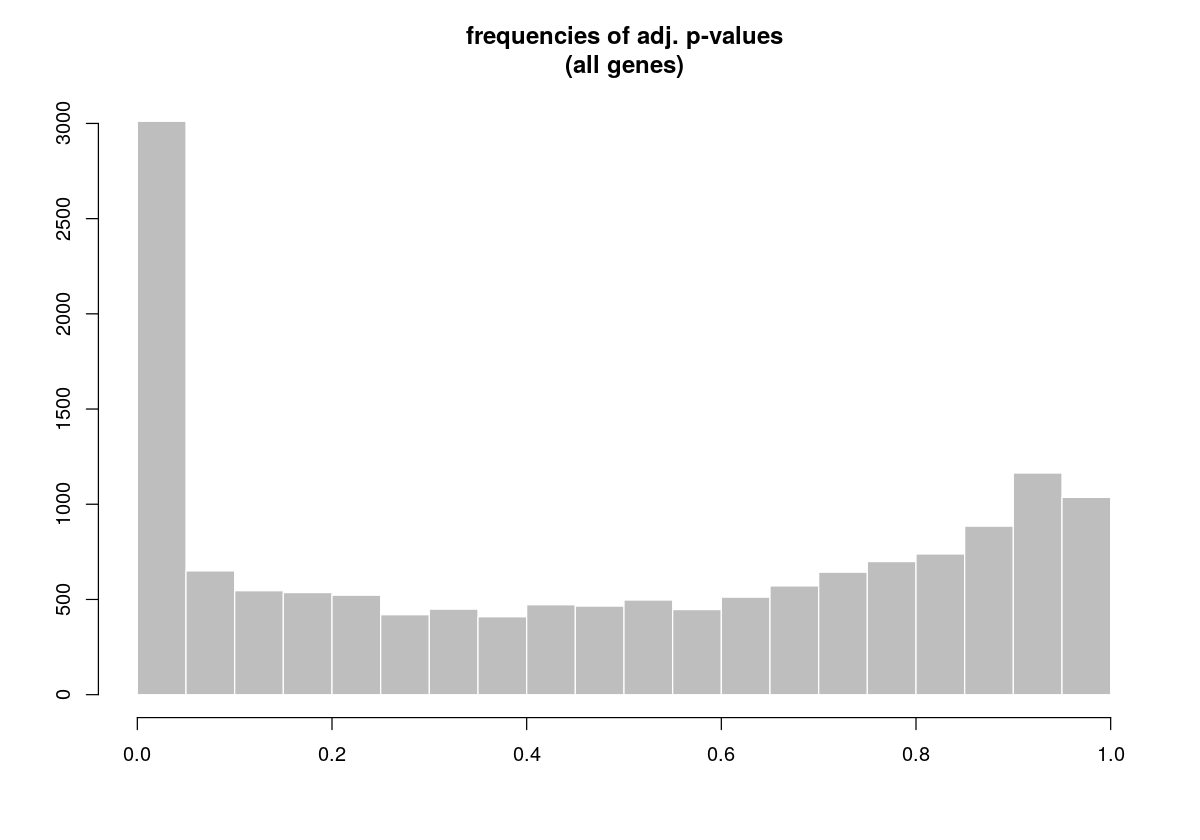

In [59]:
hist(res$padj, 
     col="grey", 
     border="white", 
     xlab="", 
     ylab="", 
     main="frequencies of adj. p-values\n(all genes)")

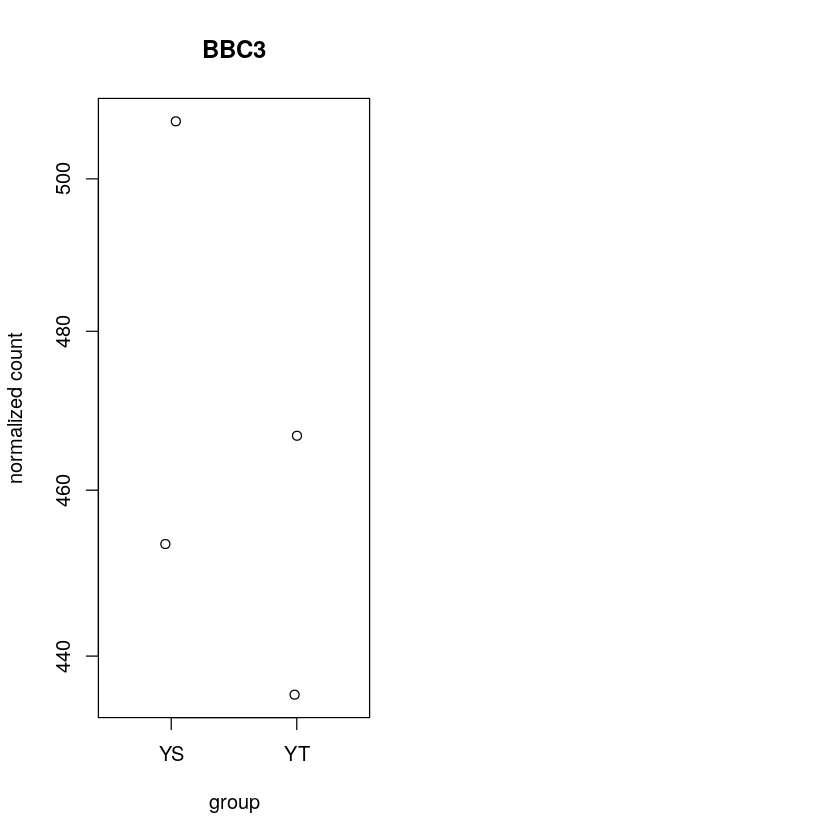

In [21]:
par(mfrow=c(1,2))
plotCounts(dds, gene="CDKN2A", normalized = TRUE) 

In [60]:
res <- cbind(Gene = rownames(res), data.frame(res, row.names=NULL))
write.table(res, "deseq.results.tsv", sep="\t", row.names=FALSE, quote=FALSE)

In [61]:
res.nona <- res[!is.na(res$log2FoldChange) & !is.na(res$padj),]
res.upreg <- res.nona[res.nona$log2FoldChange>1 & res.nona$padj<0.05,]
res.downreg <- res.nona[res.nona$log2FoldChange<1 & res.nona$padj<0.05,]

genes.upreg <- DataFrame("Genes" = rownames(res.upreg))
genes.downreg <- DataFrame("Genes" = rownames(res.downreg))
# genes.sigreg <- rbind(genes.upreg, genes.downreg)

In [62]:
write.table(genes.upreg, "up-logFC1-p05.txt", col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(genes.upreg, "down-logFC1-p05.txt", col.names=FALSE, row.names=FALSE, quote=FALSE)

In [69]:
res[res$Gene=='CDKN2A',]

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10665,CDKN2A,369.6355,0.1649249,0.2932108,0.56286,0.5735302,0.7890679


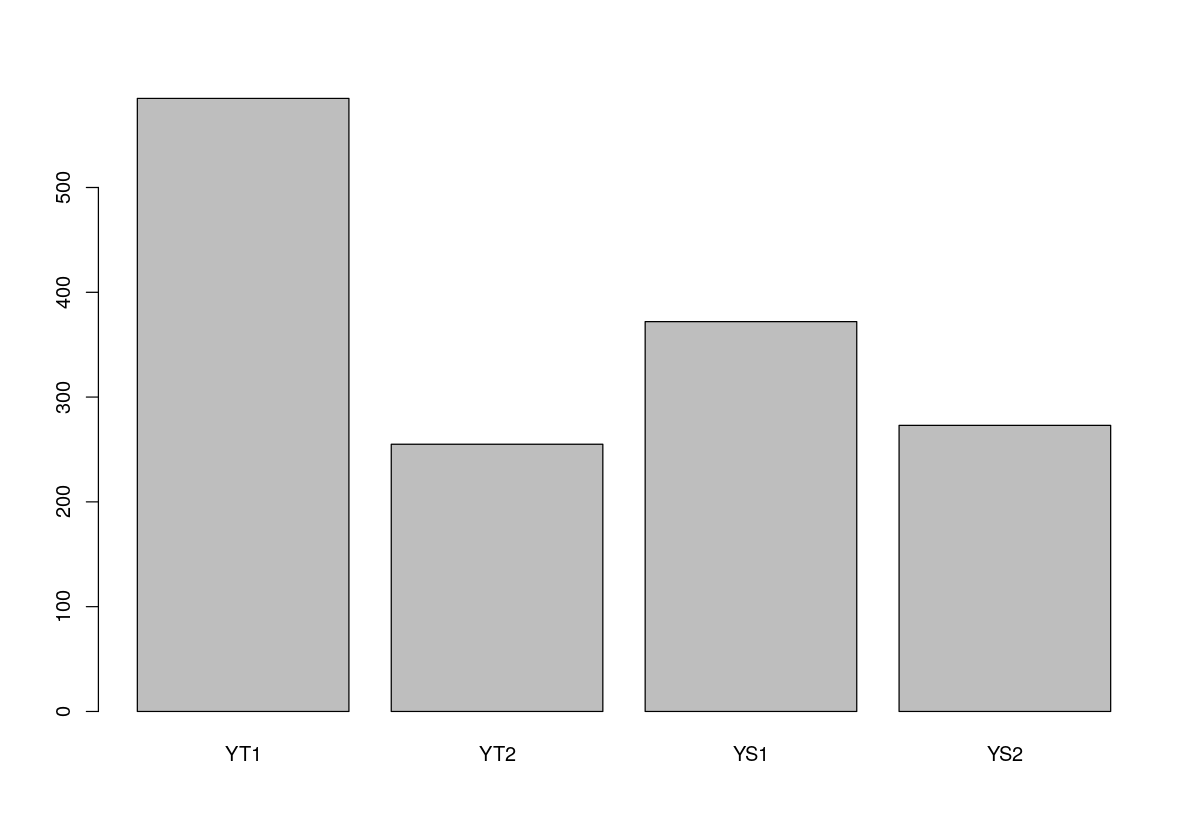

In [70]:
barplot(counts(dds)["CDKN2A",])

In [27]:
res.sorted <- res[order(res$padj),]
head(res.sorted)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,RCVRN,13012.063,-5.036222,0.1072400,-46.96218,0.000000e+00,0.000000e+00
2,SUSD2,3750.298,-3.234529,0.1323050,-24.44753,5.346482e-132,4.042475e-128
3,UHRF1,2481.167,3.388201,0.1542755,21.96202,6.647767e-107,3.350918e-103
4,MYO5B,1840.630,-2.759343,0.1260762,-21.88631,3.508137e-106,1.320324e-102
5,DBH-AS1,707.606,-5.302735,0.2423960,-21.87633,4.365574e-106,1.320324e-102
6,SEPT4,3776.764,-2.211199,0.1037013,-21.32276,6.981266e-101,1.759512e-97


In [74]:
# identify genes with the desired adjusted p-value cut-off
DGEgenes <- subset(res.sorted, padj < 0.05)$Gene
DGEgenes

[1] RCVRN          SUSD2          UHRF1          MYO5B         
   [5] DBH-AS1        SEPT4          OLAH           C2orf71       
   [9] NPTX1          PRPH2          SARDH          ELAVL3        
  [13] PDE6H          CDKN1A         MDGA1          ANKRD33       
  [17] RHOB           MYCL           TXNIP          RP1L1         
  [21] CHST1          DBH            CTNNA2         LEFTY2        
  [25] TFF1           NR2E3          SYT17          PDE6C         
  [29] CTD-2116F7.1   CTD-2521M24.11 CTD-2532D12.4  ATP1B1        
  [33] DLG5           ITPR3          JARID2         TNC           
  [37] HMGB2          TNR            GSN            DCAF16        
  [41] SLC13A2        HEG1           CACNA2D1       CGNL1         
  [45] MVP            ESPN           ABI2           UNC13D        
  [49] GRM4           CHRNA9         GUCA1A         S1PR3         
  [53] DSP            GUCA1B         GNLY           KPNA3         
  [57] RBPJ           FAM179A        LOXL1-AS1      TBCD          
  [61] RNF152         RSPO1          LPHN3          SNX29         
  [65] ZEB2           E2F7           EPAS1          DRAXIN        
  [69] DOCK8          CLDN5          ALDH9A1        MYH11         
  [73] BTBD2          SYTL4          GNAT2          FRMD3         
  [77] PLXNA2         RALBP1         TAGLN2         TRIM33        
  [81] UNC119         PHLDB2         CAMKV          ITGA8         
  [85] DPYSL5         SLC35E2B       SMC2           SHF           
  [89] NDRG1          IMPG1          CACNA1G        AQP1          
  [93] CACNA1S        FLNB           MRPS27         GNA12         
  [97] HSPA4L         ATAD2          RNF41          DPP4          
 [101] KLF2           TBC1D14        PITPNA         S100A13       
 [105] INSIG1         GPRIN3         MICAL2         COX6C         
 [109] RP1            FYCO1          SEMA6D         NEURL         
 [113] ARHGAP26       ARL4C          TDRG1          SOX6          
 [117] GNGT2          CDHR1          CKM            MFI2          
 [121] IGSF9          GMFB           S100A16        AMOTL2        
 [125] LRRC8B         TMEM194A       TUSC3          MXRA5         
 [129] LRRC55         VTN            NEDD4L         NLN           
 [133] NCMAP          CTD-3064M3.4   TTYH3          OSBP2         
 [137] GPR116         ACOT11         NCS1           CABP5         
 [141] MBOAT2         DLST           AQP3           NRBP1         
 [145] SHD            DKK3           RBM47          TMEM170A      
 [149] CELF4          MYH14          VMP1           C14orf132     
 [153] TDRD7          EDC4           NRP2           USP37         
 [157] PTER           GALNT14        TMEM184A       PTPN9         
 [161] NUP43          VHL            LYPD2          CHP1          
 [165] SPRED2         GGT5           RHOU           SLC39A10      
 [169] CUL4A          ROM1           ALDOC          PAN2          
 [173] GFRA1          RP11-214O1.2   NOLC1          SLC39A11      
 [177] ZBTB38         AC020601.1     KCNH6          RP11-345P4.9  
 [181] PROM1          NEDD9          TRPV2          RNH1          
 [185] C7orf33        KCNN1          TRPC7          TSPAN14       
 [189] NCR3LG1        GABBR2         ZFP36L1        WDR45B        
 [193] SAG            SFRP2          PFKP           ITPKB         
 [197] SPON1          IL13RA1        TRAF3          GLUL          
 [201] GNAT1          CERS6          PTPN11         BHLHE40       
 [205] PCP2           KEL            SAMD4A         BCKDK         
 [209] CBX2           ALK            PRTFDC1        SDPR          
 [213] COLGALT1       RNF40          RAC1           SLC28A3       
 [217] SHISA5         KLF6           GRK1           SGK1          
 [221] EMILIN3        MEIS2          CAV3           LINC00662     
 [225] LINC00883      TPGS2          GGA2           RCAN3         
 [229] XRCC6          RD3            COL18A1        TNPO1         
 [233] CCM2           GMPR           SMARCC2        CHST2         
 [237] GJD2           KIAA1755       PSD4         

In [29]:
# extract rlog-transformed values into a matrix
hm.mat_DGEgenes <- rlog.norm.counts[DGEgenes,]

ERROR: Error in eval(expr, envir, enclos): object 'rlog.norm.counts' not found


In [ ]:
library(pheatmap)
# heatmap of DEG sorted by p.adjust
pheatmap(hm.mat_DGEgenes, scale="none", show_rownames = FALSE, main = "DGE (no scaling)")
pheatmap(hm.mat_DGEgenes, scale="row", show_rownames = FALSE, main = "DGE (row-based z-score)")